In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

from itertools import islice

In [2]:
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from estimator import SwitchTransformerEstimator

/home/kashif/.env/pytorch/lib/python3.8/site-packages/horovod/common/util.py:258: UserWarning: Framework pytorch installed with version 1.12.0a0+git689df63 but found version 1.13.0a0+git9e80661.
             This can result in unexpected behavior including runtime errors.
             Reinstall Horovod using `pip install --no-cache-dir` to build with the new version.
  warnings.warn(get_version_mismatch_message(name, version, installed_version))


In [3]:
dataset = get_dataset("electricity")

In [18]:
estimator = SwitchTransformerEstimator(
    freq=dataset.metadata.freq,
    prediction_length=dataset.metadata.prediction_length,
    context_length=8*dataset.metadata.prediction_length,
    num_feat_static_cat=1,
    cardinality=[321],
    embedding_dimension=[3],
    
    dim_feedforward=16,
    num_encoder_layers=2,
    num_decoder_layers=2,
    nhead=2,
    n_experts=4,
    capacity_factor=1.0,
    
    activation="relu",

    batch_size=128,
    num_batches_per_epoch=100,
    trainer_kwargs=dict(max_epochs=20, accelerator='gpu', gpus=1),
)

In [19]:
predictor = estimator.train(
    training_data=dataset.train,
    num_workers=8,
    shuffle_buffer_length=1024
)

/home/kashif/.env/pytorch/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(
/home/kashif/.env/pytorch/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kashif/.env/pytorch/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:133: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `valida

Training: 0it [00:00, ?it/s]

/home/kashif/.env/pytorch/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (_ResultMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
Epoch 0, global step 100: 'train_loss' reached 6.89574 (best 6.89574), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/switch/light

In [20]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test, 
    predictor=predictor
)

In [21]:
forecasts = list(forecast_it)

In [8]:
tss = list(ts_it)

In [22]:
evaluator = Evaluator()

In [23]:
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))


Running evaluation: 2247it [00:00, 4999.89it/s]
/home/kashif/.env/pytorch/lib/python3.8/site-packages/pandas/core/construction.py:781: UserWarning: Warning: converting a masked element to nan.
  subarr = np.array(arr, dtype=dtype, copy=copy)


In [11]:
agg_metrics

{'MSE': 2308789.695387119,
 'abs_error': 9913947.80090332,
 'abs_target_sum': 128632956.0,
 'abs_target_mean': 2385.272140631954,
 'seasonal_error': 189.49338196116761,
 'MASE': 0.782350009562839,
 'MAPE': 0.10093158438717875,
 'sMAPE': 0.11210628837831137,
 'MSIS': 6.093644166414652,
 'QuantileLoss[0.1]': 4243983.490897928,
 'Coverage[0.1]': 0.12959872422489244,
 'QuantileLoss[0.2]': 6717838.2415222265,
 'Coverage[0.2]': 0.24310191366266132,
 'QuantileLoss[0.3]': 8384472.076653192,
 'Coverage[0.3]': 0.3441625871532414,
 'QuantileLoss[0.4]': 9423126.726327974,
 'Coverage[0.4]': 0.4417742174751521,
 'QuantileLoss[0.5]': 9913947.8229811,
 'Coverage[0.5]': 0.5353619641002819,
 'QuantileLoss[0.6]': 9806506.761595396,
 'Coverage[0.6]': 0.6134661029520843,
 'QuantileLoss[0.7]': 9047604.118984528,
 'Coverage[0.7]': 0.6995067497403945,
 'QuantileLoss[0.8]': 7602965.167928445,
 'Coverage[0.8]': 0.7845460614152203,
 'QuantileLoss[0.9]': 5178201.723310344,
 'Coverage[0.9]': 0.8760384215991693,
 '

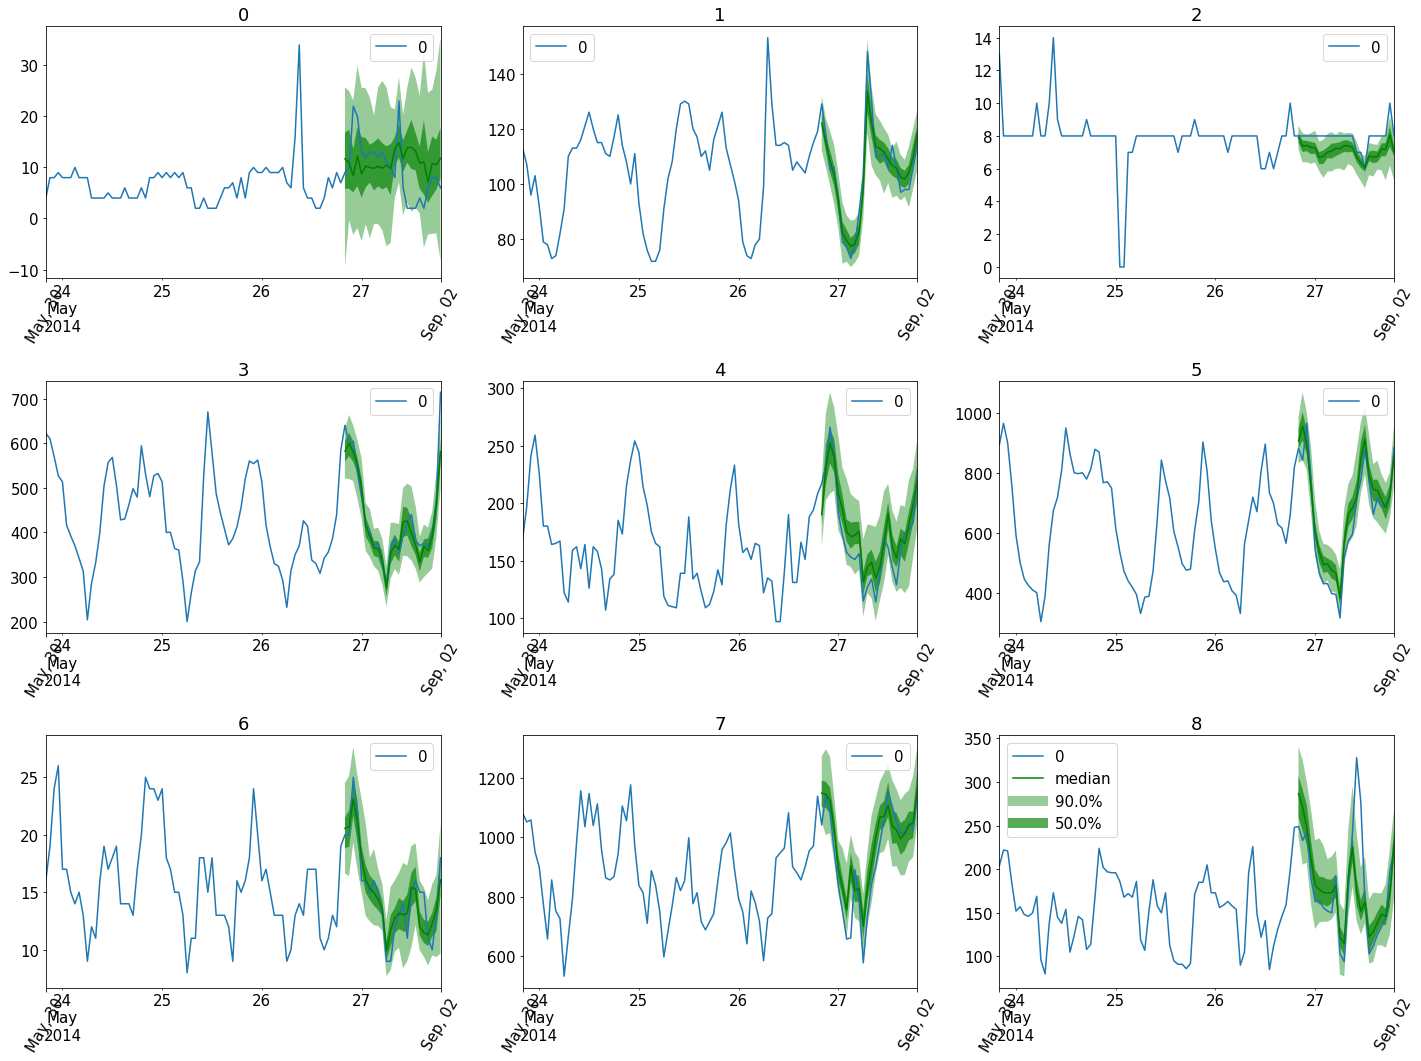

In [14]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    ts[-4 * dataset.metadata.prediction_length:].plot(ax=ax, label="target",)
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    plt.title(forecast.item_id)
    ax.xaxis.set_major_formatter(date_formater)

plt.gcf().tight_layout()
plt.legend()
plt.show()